In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
import warnings
from sklearn.exceptions import DataConversionWarning
# ignore all scikit-learn warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import StandardScaler


#### Read Data

In [98]:
df=pd.read_csv("./Dataset/bikesCleaned.csv")
df.head()

,Unnamed: 0,name,brand,price,max power,max torque,cooling system,transmission,transmission type,displacement,...,front tyre pressure (rider & pillion),rear tyre pressure (rider & pillion),kerb weight,overall length,overall width,wheelbase,ground clearance,seat height,overall height,chassis type
0,0,Royal Enfield Hunter 350,Royal Enfield,149900,20.2,27.0,air/oil cooled,5 speed manual,chain drive,349.0,...,29.0,33.0,177.0,2055,800.0,1370,150.0,790,1055,double-downtube frame
1,1,Royal Enfield Classic 350,Royal Enfield,190229,20.2,27.0,air/oil cooled,5 speed manual,chain drive,349.0,...,22.0,32.0,195.0,2145,785.0,1390,170.0,805,1090,twin downtube spine frame
2,2,Royal Enfield Bullet 350,Royal Enfield,157391,19.1,28.0,air cooled,5 speed manual,chain drive,346.0,...,22.0,32.0,186.0,2170,810.0,1395,135.0,800,1120,"single downtube,using engine as stressed member"
3,3,Royal Enfield Continental GT 650,Royal Enfield,304945,47.0,52.0,air/oil cooled,6 speed manual,chain drive,648.0,...,32.0,39.0,198.0,2122,744.0,1398,174.0,793,1024,"steel tubular, double cradle frame"
4,4,Royal Enfield Meteor 350,Royal Enfield,200924,20.2,27.0,air/oil cooled,5 speed manual,chain drive,349.0,...,32.0,36.0,191.0,2140,845.0,1400,170.0,765,1140,twin downtube spine frame


### Data Preprocessing
#### Using pandas_profiling for EDA

In [99]:
# from pandas_profiling import ProfileReport
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

In [100]:
df.shape

(173, 45)

In [101]:
df.count()

Unnamed: 0                               173
name                                     173
brand                                    173
price                                    173
max power                                173
max torque                               173
cooling system                           173
transmission                             173
transmission type                        173
displacement                             173
cylinders                                173
bore                                     173
stroke                                   173
valves per cylinder                      173
spark plugs                              173
gear shifting pattern                    173
clutch                                   173
fuel tank capacity                       173
mileage - arai                            38
mileage - owner reported                 110
top speed                                173
braking system                           173
front brak

In [102]:
# find correlation of price with other features
h=df.corr()['price']
# get features which has correlation of price with other features greater than 50%
h = df.corr()['price']
h = h[h > 0.5]
h

price                                    1.000000
max power                                0.899191
max torque                               0.849956
displacement                             0.761933
cylinders                                0.773806
bore                                     0.553585
fuel tank capacity                       0.534874
top speed                                0.804045
rear brake size                          0.501127
front tyre pressure (rider)              0.679589
rear tyre pressure (rider)               0.600355
front tyre pressure (rider & pillion)    0.690404
kerb weight                              0.641060
wheelbase                                0.605229
Name: price, dtype: float64

In [103]:
## selectd columns are name,brand,max power,max torque ,fuel tank capacity,top speed,kerb weight,overall_height,overall_lenght,overall_width,wheelbase,braking system
columns=["name","brand","max power","max torque" ,"fuel tank capacity","top speed","kerb weight","overall height","overall length","overall width","wheelbase","front brake type","price"]

In [104]:
# get remainnig columns other than selected columns
remaining_cols = set(df.columns) - set(columns)
print(list(remaining_cols))

['cylinders', 'rear wheel size', 'tyre type', 'seat height', 'rear brake size', 'chassis type', 'wheel type', 'clutch', 'valves per cylinder', 'rear tyre pressure (rider)', 'front brake size', 'rear brake type', 'Unnamed: 0', 'rear tyre size', 'mileage - owner reported', 'front tyre size', 'cooling system', 'front wheel size', 'bore', 'rear tyre pressure (rider & pillion)', 'stroke', 'gear shifting pattern', 'spark plugs', 'displacement', 'mileage - arai', 'ground clearance', 'transmission', 'transmission type', 'braking system', 'radial tyres', 'front tyre pressure (rider)', 'front tyre pressure (rider & pillion)']


In [105]:
# drop all remaining columns
df_updated = df.drop(remaining_cols, axis=1)
df_updated

,name,brand,price,max power,max torque,fuel tank capacity,top speed,front brake type,kerb weight,overall length,overall width,wheelbase,overall height
0,Royal Enfield Hunter 350,Royal Enfield,149900,20.20,27.0,13.0,114.0,disc,177.0,2055,800.0,1370,1055
1,Royal Enfield Classic 350,Royal Enfield,190229,20.20,27.0,13.0,114.0,disc,195.0,2145,785.0,1390,1090
2,Royal Enfield Bullet 350,Royal Enfield,157391,19.10,28.0,13.5,110.0,disc,186.0,2170,810.0,1395,1120
3,Royal Enfield Continental GT 650,Royal Enfield,304945,47.00,52.0,12.5,169.0,disc,198.0,2122,744.0,1398,1024
4,Royal Enfield Meteor 350,Royal Enfield,200924,20.20,27.0,15.0,112.0,disc,191.0,2140,845.0,1400,1140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Vespa SXL 125,Vespa,134313,9.78,9.6,7.4,90.0,disc,114.0,1770,690.0,1290,1140
169,Vespa SXL 150,Vespa,148261,10.32,10.6,7.4,95.0,disc,114.0,1770,690.0,1290,1140
170,Vespa VXL 125,Vespa,130438,9.78,9.6,7.4,90.0,disc,114.0,1770,690.0,1290,1140
171,Vespa VXL 150,Vespa,143895,10.32,10.6,7.4,95.0,disc,114.0,1770,690.0,1290,1140


In [106]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                173 non-null    object 
 1   brand               173 non-null    object 
 2   price               173 non-null    int64  
 3   max power           173 non-null    float64
 4   max torque          173 non-null    float64
 5   fuel tank capacity  173 non-null    float64
 6   top speed           173 non-null    float64
 7   front brake type    173 non-null    object 
 8   kerb weight         173 non-null    float64
 9   overall length      173 non-null    int64  
 10  overall width       173 non-null    float64
 11  wheelbase           173 non-null    int64  
 12  overall height      173 non-null    int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 17.7+ KB


In [107]:
#unique values of front brake type feature
print(df_updated["front brake type"].unique())
print("Unique Count : ",df_updated["front brake type"].nunique())

['disc' 'drum']
Unique Count :  2


In [108]:
#unique values of brand feature
print(df_updated["brand"].unique())
print("Unique Count : ",df_updated["brand"].nunique())

['Royal Enfield' 'TVS' 'Hero' 'Bajaj' 'Honda' 'Yamaha' 'Suzuki' 'KTM'
 'Jawa' 'Kawasaki' 'Aprilia' 'Benelli' 'CFMoto' 'Ducati' 'Husqvarna'
 'Triumph' 'Vespa']
Unique Count :  17


In [109]:
#unique values of name feature
print(df_updated["name"].unique())
print("Unique Count : ",df_updated["name"].nunique())

['Royal Enfield Hunter 350' 'Royal Enfield Classic 350'
 'Royal Enfield Bullet 350' 'Royal Enfield Continental GT 650'
 'Royal Enfield Meteor 350' 'Royal Enfield Himalayan'
 'Royal Enfield Interceptor 650' 'Royal Enfield Scram 411'
 'TVS Raider 125' 'Apache' 'TVS Ronin' 'TVS Ntorq 125' 'TVS Sport'
 'TVS Jupiter' 'TVS Jupiter 125' 'TVS Star City Plus' 'TVS Radeon'
 'TVS Scooty Pep Plus' 'TVS XL100 Heavy Duty' 'TVS Scooty Zest 110'
 'TVS XL100 Comfort' 'Splendor' 'Hero Splendor Plus Xtec' 'Hero HF Deluxe'
 'Hero Xtreme 160R' 'Hero Glamour' 'Hero Passion Pro' 'Hero Xpulse 200 4V'
 'Hero Pleasure +' 'Hero Passion Xtec' 'Hero Glamour Xtec'
 'Hero Xpulse 200T 4V' 'Hero Xtreme 200S' 'Hero Pleasure + Xtec'
 'Hero Maestro Edge 125' 'Hero Destini 125 Xtec' 'Hero Maestro Edge 110'
 'Pulsar' 'Platina' 'Bajaj Dominar 400' 'Bajaj Dominar 250' 'Bajaj CT 110'
 'Bajaj CT 125X' 'Avenger' 'Honda SP 125' 'Activa' 'Honda Shine'
 'Honda Unicorn' 'Honda Dio' 'Honda Hornet 2.0' 'Honda Hness CB350'
 'Honda Liv

In [110]:
#Null value check
df_updated.isnull().sum()

name                  0
brand                 0
price                 0
max power             0
max torque            0
fuel tank capacity    0
top speed             0
front brake type      0
kerb weight           0
overall length        0
overall width         0
wheelbase             0
overall height        0
dtype: int64

### Split the data

In [111]:
#define X and Y
X=df_updated.drop(columns=['price'])
y=df_updated['price']

In [112]:
X

,name,brand,max power,max torque,fuel tank capacity,top speed,front brake type,kerb weight,overall length,overall width,wheelbase,overall height
0,Royal Enfield Hunter 350,Royal Enfield,20.20,27.0,13.0,114.0,disc,177.0,2055,800.0,1370,1055
1,Royal Enfield Classic 350,Royal Enfield,20.20,27.0,13.0,114.0,disc,195.0,2145,785.0,1390,1090
2,Royal Enfield Bullet 350,Royal Enfield,19.10,28.0,13.5,110.0,disc,186.0,2170,810.0,1395,1120
3,Royal Enfield Continental GT 650,Royal Enfield,47.00,52.0,12.5,169.0,disc,198.0,2122,744.0,1398,1024
4,Royal Enfield Meteor 350,Royal Enfield,20.20,27.0,15.0,112.0,disc,191.0,2140,845.0,1400,1140
...,...,...,...,...,...,...,...,...,...,...,...,...
168,Vespa SXL 125,Vespa,9.78,9.6,7.4,90.0,disc,114.0,1770,690.0,1290,1140
169,Vespa SXL 150,Vespa,10.32,10.6,7.4,95.0,disc,114.0,1770,690.0,1290,1140
170,Vespa VXL 125,Vespa,9.78,9.6,7.4,90.0,disc,114.0,1770,690.0,1290,1140
171,Vespa VXL 150,Vespa,10.32,10.6,7.4,95.0,disc,114.0,1770,690.0,1290,1140


In [113]:
# train/test/split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


### Using ColumnTransformer to perform columnwise transformation

In [114]:
from sklearn.compose import ColumnTransformer

In [115]:
# one hot encoding on name,brand,front_brake_type columns
trf1_RFR = ColumnTransformer([ 
    ('ohe_name', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0]),
    ('ohe_brand', OneHotEncoder(sparse=False, handle_unknown='ignore'), [1]),
    ('ohe_front_brake_type', OneHotEncoder(sparse=False, handle_unknown='ignore'), [6]),
    ('scaling', StandardScaler(), [2, 3, 4, 5, 7, 8, 9, 10])
])


In [116]:
# # one hot encoding on name,brand,front_brake_type columns
# from sklearn.preprocessing import StandardScaler

# trf1_DTR = ColumnTransformer([ 
#     ('ohe_name', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0]),
#     ('ohe_brand', OneHotEncoder(sparse=False, handle_unknown='ignore'), [1]),
#     ('ohe_front_brake_type', OneHotEncoder(sparse=False, handle_unknown='ignore'), [6]),
#     ('scaling', StandardScaler(), [2, 3, 4, 5, 7, 8, 9, 10])
# ], remainder='passthrough')

In [117]:

trf1_DTR = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 1, 6]),
    ('scaling', StandardScaler(), [2, 3, 4, 5, 7, 8, 9, 10])
])

### Train the model with pipeline

In [118]:
# train the model
from sklearn.ensemble import RandomForestRegressor
trf2_RFR = RandomForestRegressor(n_estimators=200, criterion='squared_error')

In [119]:
from sklearn.tree import DecisionTreeRegressor
trf2_DTR= DecisionTreeRegressor(random_state=42)

In [120]:
from sklearn.ensemble import AdaBoostRegressor
trf2_ABR= AdaBoostRegressor()

In [121]:
from sklearn.linear_model import ElasticNet
trf2_ENR=ElasticNet(alpha=0.1, l1_ratio=0.5)

In [122]:
# Display Pipeline diagram
from sklearn import set_config
set_config(display='diagram')

In [123]:
# crating the pipeline based on above column transformation
from sklearn.pipeline import Pipeline,make_pipeline
pipe = Pipeline([
    ('trf1_RFR',trf1_RFR),
    ('trf2_RFR',trf2_RFR),])
# train pipeline
pipe.fit(X_train,y_train)

Pipeline(steps=[('trf1_RFR',
                 ColumnTransformer(transformers=[('ohe_name',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [0]),
                                                 ('ohe_brand',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1]),
                                                 ('ohe_front_brake_type',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [6]),
                                                 ('scaling', StandardScaler(),
                                                  [2, 3, 4, 5, 7, 8, 9, 10])])),
                ('trf2_RFR', RandomForestRegressor(n_estimators=200))])

In [124]:
pipe2 = Pipeline([
    ('trf1_DTR',trf1_DTR),
    ('trf2_DTR',trf2_DTR),])
pipe2.fit(X_train,y_train)

Pipeline(steps=[('trf1_DTR',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [0, 1, 6]),
                                                 ('scaling', StandardScaler(),
                                                  [2, 3, 4, 5, 7, 8, 9, 10])])),
                ('trf2_DTR', DecisionTreeRegressor(random_state=42))])

In [125]:
pipe3 = Pipeline([
    ('trf1_DTR',trf1_DTR),
    ('trf2_ABR',trf2_ABR),])
pipe3.fit(X_train,y_train)

Pipeline(steps=[('trf1_DTR',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [0, 1, 6]),
                                                 ('scaling', StandardScaler(),
                                                  [2, 3, 4, 5, 7, 8, 9, 10])])),
                ('trf2_ABR', AdaBoostRegressor())])

In [126]:
pipe4 = Pipeline([
    ('trf1_DTR',trf1_DTR),
    ('trf2_ENR',trf2_ENR),])
pipe4.fit(X_train,y_train)

Pipeline(steps=[('trf1_DTR',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [0, 1, 6]),
                                                 ('scaling', StandardScaler(),
                                                  [2, 3, 4, 5, 7, 8, 9, 10])])),
                ('trf2_ENR', ElasticNet(alpha=0.1))])

In [127]:
# Predict
y_pred_RFR = pipe.predict(X_test)
y_pred_RFR

array([1256049.82333333,  105703.31      ,   80109.935     ,
         71359.555     ,  811977.995     , 2086416.2       ,
         71390.49      ,  146703.67      , 2171138.2       ,
       2734345.95      ,  124578.58      ,  122075.89      ,
       1390205.035     ,   68982.92      ,   75758.805     ,
        131406.185     ,  697706.995     ,  132585.62      ,
         54414.775     ,  219291.79      ,  127737.83      ,
        164316.79      , 1056711.945     ,  132914.195     ,
         80984.19      ,  196287.575     , 2112046.74      ,
         70972.535     ,   72145.74      , 2136354.29      ,
         80926.91      ,  131379.01      ,   81824.61      ,
       1421028.285     , 2295314.95      ])

In [128]:
# Predict
y_pred_DTR = pipe2.predict(X_test)
y_pred_DTR

array([1139000.,   90524.,   84568.,   71502.,  732773., 2372222.,
         75471.,  135257., 1139000., 2372222.,  134313.,  113636.,
       1219000.,   75471.,   71674.,  105884.,  643034.,  104982.,
         47140.,  236090.,  135240.,  180687., 1069000.,  135240.,
         83086.,  236090., 2148000.,   71674.,   75471., 2372222.,
         78627.,  105884.,   83273., 1605000., 2372222.])

In [129]:
y_pred_ABR = pipe3.predict(X_test)
y_pred_ABR

array([1559597.72340426,  185521.62337662,  185521.62337662,
        185521.62337662,  857769.90909091, 2075900.42424242,
        185521.62337662,  185521.62337662, 2068423.54716981,
       2173426.42857143,  185521.62337662,  185521.62337662,
       1288390.54237288,  185521.62337662,  185521.62337662,
        185521.62337662,  830752.69565217,  185521.62337662,
        185521.62337662,  185521.62337662,  185521.62337662,
        185521.62337662, 1097190.90196078,  185521.62337662,
        185521.62337662,  293453.6875    , 2157110.80555556,
        185521.62337662,  185521.62337662, 2109710.85      ,
        185521.62337662,  185521.62337662,  185521.62337662,
       1330098.51724138, 2162811.63043478])

In [130]:
y_pred_ENR = pipe4.predict(X_test)
y_pred_ENR

array([1446495.83252581,   84710.94708673,   13085.25272287,
         96680.04579878,  900394.64969143, 2861498.10069459,
        117327.54671497,  133217.39286091, 2442097.46416006,
       3172275.76267319,  -72296.47225102,  -15298.16027797,
       1432449.63047552,  108479.13691042,   25068.76423983,
        -26889.39842029,  965900.48745849,  -69015.77825214,
        -30219.55874337,  253648.35591137,  -46298.38495427,
        220823.3519008 , 1161825.87385155,   50822.18521715,
        107603.61883758,  147657.16560857, 2440628.81210716,
         31874.33267044,  -10730.59355994, 2876113.3009196 ,
         65781.25239112,   -6033.20121717,  119814.53097889,
       1497141.56356104, 2895174.26801808])

In [131]:
# Evaluate the performance of the model on the test data using R-squared
from sklearn.metrics import r2_score
r2_RFR = r2_score(y_test, y_pred_RFR)
print("R-squared RFR:", r2_RFR)

# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cv_scores_RFR = cross_val_score(pipe, X_train, y_train, cv=15)
print("Mean R-squared Cross-validation R-squared scores:", cv_scores_RFR.mean())


R-squared RFR: 0.8718890741891747
Mean R-squared Cross-validation R-squared scores: 0.8261691750180506


In [132]:
# Evaluate the performance of the model on the test data using R-squared
from sklearn.metrics import r2_score
r2_DTR = r2_score(y_test, y_pred_DTR)
print("R-squared DTR:", r2_DTR)

# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cv_scores_DTR = cross_val_score(pipe2, X_train, y_train, cv=15)
print("Mean R-squared Cross-validation R-squared score:", cv_scores_DTR.mean())

R-squared DTR: 0.9513093757774449
Mean R-squared Cross-validation R-squared score: 0.6920999283196864


In [145]:
# Evaluate the performance of the model on the test data using R-squared
from sklearn.metrics import r2_score
r2_ABR = r2_score(y_test, y_pred_ABR)
print("R-squared ABR:", r2_ABR)

# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cv_scores_ABR = cross_val_score(pipe3, X_train, y_train, cv=15)
print("Mean R-squared Cross-validation R-squared score:", cv_scores_ABR.mean())

R-squared ABR: 0.9032347022426749
Mean R-squared Cross-validation R-squared score: 0.7546804106241677


In [146]:
# Evaluate the performance of the model on the test data using R-squared
from sklearn.metrics import r2_score
r2_ENR = r2_score(y_test, y_pred_ENR)
print("R-squared ENR:", r2_ENR)

# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cv_scores_ENR = cross_val_score(pipe4, X_train, y_train, cv=15)
print("Mean R-squared Cross-validation R-squared score:", cv_scores_ENR.mean())

R-squared ENR: 0.7492263989711121
Mean R-squared Cross-validation R-squared score: 0.7134493701557839


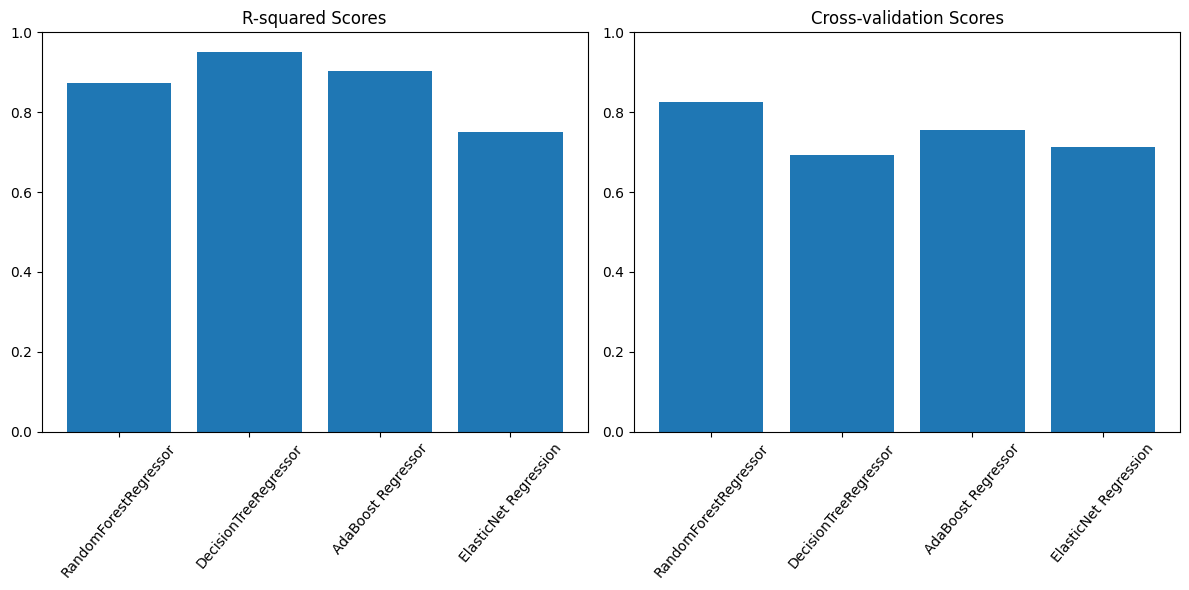

In [147]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot R-squared scores
plt.subplot(1, 2, 1)
plt.bar(['RandomForestRegressor', 'DecisionTreeRegressor','AdaBoost Regressor','ElasticNet Regression'], [r2_RFR, r2_DTR, r2_ABR, r2_ENR])
plt.ylim(0,1)
plt.title('R-squared Scores')
plt.xticks(rotation=50)

# Plot cross-validation scores
plt.subplot(1, 2, 2)
plt.bar(['RandomForestRegressor', 'DecisionTreeRegressor','AdaBoost Regressor','ElasticNet Regression'], [cv_scores_RFR.mean(), cv_scores_DTR.mean(), cv_scores_ABR.mean(), cv_scores_ENR.mean()])
plt.ylim(0,1)
plt.title('Cross-validation Scores')
plt.xticks(rotation=50)


# Display the plots
plt.tight_layout()
plt.show()


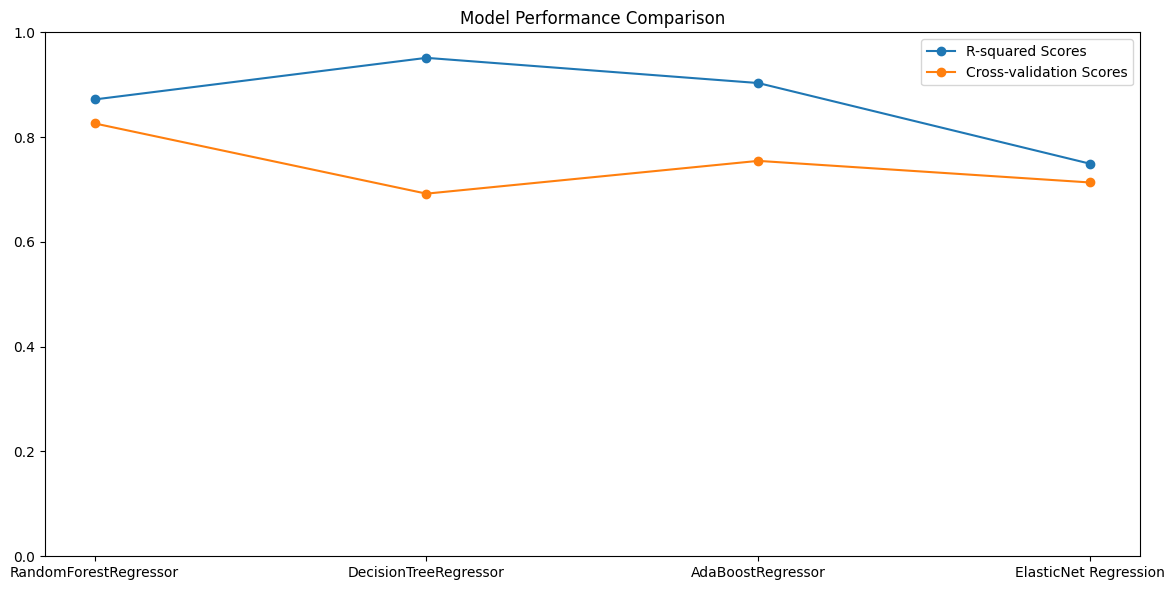

In [148]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot R-squared scores
plt.plot(['RandomForestRegressor', 'DecisionTreeRegressor', 'AdaBoostRegressor', 'ElasticNet Regression'], [r2_RFR, r2_DTR, r2_ABR, r2_ENR], marker='o', label='R-squared Scores')

# Plot cross-validation scores
plt.plot(['RandomForestRegressor', 'DecisionTreeRegressor', 'AdaBoostRegressor', 'ElasticNet Regression'], [cv_scores_RFR.mean(), cv_scores_DTR.mean(), cv_scores_ABR.mean(), cv_scores_ENR.mean()], marker='o', label='Cross-validation Scores')

plt.ylim(0, 1)
plt.title('Model Performance Comparison')
plt.legend()
plt.xticks(rotation=0)

# Display the plots
plt.tight_layout()
plt.show()


### Save and load model

In [149]:
# export 
import pickle
#pickle.dump(pipe,open('models/pipe3.pkl','wb'))
#pickle.dump(pipe,open('models/model_DTR.pkl','wb'))

In [150]:
#pipe = pickle.load(open('models/pipe3.pkl','rb'))

In [151]:
features=["name","brand","max power","max torque" ,"fuel tank capacity","top speed","front brake type","kerb weight","overall length","overall width","wheelbase","overall height","price"]
features_without_price =["name","brand","max power","max torque" ,"fuel tank capacity","top speed","front brake type","kerb weight","overall length","overall width","wheelbase","overall height"]
print(df[features].loc[[30], :])
print("----------------------------------------------------------------------------------------")
print(df[features_without_price].loc[[110], :])

            name brand  max power  max torque  fuel tank capacity  top speed  \
30  Hero Glamour  Hero      10.72        10.6                10.0       95.0   

   front brake type  kerb weight  overall length  overall width  wheelbase  \
30             drum        122.0            2051          720.0       1273   

    overall height  price  
30            1074  79029  
----------------------------------------------------------------------------------------
      name     brand  max power  max torque  fuel tank capacity  top speed  \
110  Ninja  Kawasaki       44.7        37.0                14.0      169.0   

    front brake type  kerb weight  overall length  overall width  wheelbase  \
110             disc        168.0            1990          710.0       1370   

     overall height  
110            1120  


In [152]:
test_input = df[features_without_price].loc[[30], :].to_numpy()
test_input

array([['Hero Glamour', 'Hero', 10.72, 10.6, 10.0, 95.0, 'drum', 122.0,
        2051, 720.0, 1273, 1074]], dtype=object)

In [153]:
pipe.predict(test_input)

array([80926.91])

In [154]:
pipe2.predict(test_input)

array([78627.])

In [155]:
pipe3.predict(test_input)

array([185521.62337662])

Bike Model Name: Honda Grazia
Actual Price: 82398.00
Predicted Price: 81155.87
----------------------------------------
Bike Model Name: Hero Splendor Plus Xtec
Actual Price: 76381.00
Predicted Price: 71723.05
----------------------------------------
Bike Model Name: Suzuki Gixxer
Actual Price: 130718.00
Predicted Price: 127737.83
----------------------------------------
Bike Model Name: Vespa SXL 125
Actual Price: 134313.00
Predicted Price: 132496.04
----------------------------------------
Bike Model Name: Yamaha R15 V4
Actual Price: 180687.00
Predicted Price: 178408.77
----------------------------------------
Bike Model Name: Hero Pleasure + Xtec
Actual Price: 78913.00
Predicted Price: 68982.92
----------------------------------------


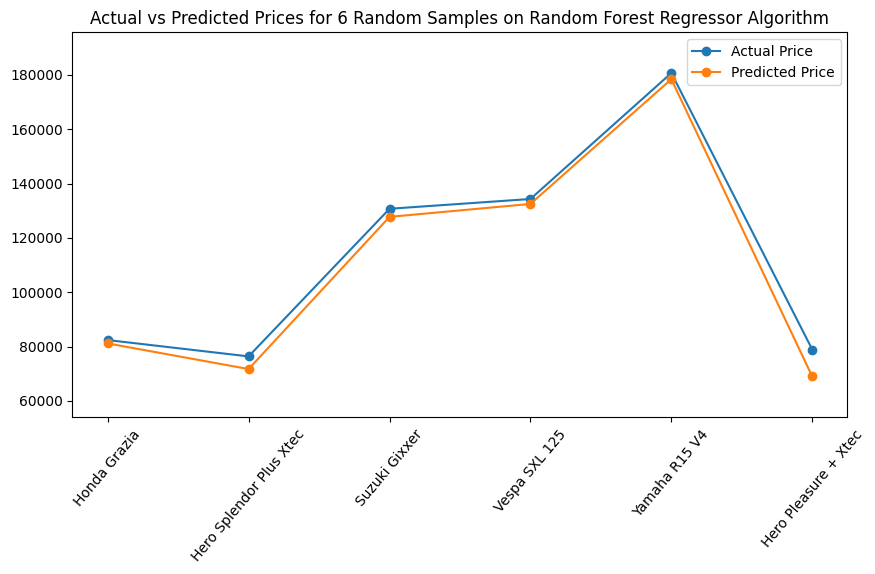

In [177]:
import matplotlib.pyplot as plt
import random

# Get 6 random indices from the dataframe
random_indices = random.sample(range(len(df)), 6)

#Create empty lists for actual and predicted prices
actual_prices = []
predicted_prices = []

# Loop through the selected indices and get the actual and predicted prices
for i in random_indices:
    # get the actual price
    actual_price = df.loc[i, "price"]
    
    # Get the input features for the prediction
    input_features = df.loc[i, features_without_price].to_numpy().reshape(1, -1)
    
    # Make the prediction
    predicted_price = pipe.predict(input_features)[0]
    
    # Append the actual and predicted prices to the lists
    actual_prices.append(actual_price)
    predicted_prices.append(predicted_price)

    # Print the results
    print(f"Bike Model Name: {df.loc[i, 'name']}")
    print(f"Actual Price: {actual_price:.2f}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print("----------------------------------------")

# Create a list of labels for the x-axis
x_labels = [df_updated.loc[i, 'name'] for i in random_indices]

# Set the size of the figure
plt.figure(figsize=(10, 5))

# Create the line graph
plt.plot(x_labels, actual_prices, label='Actual Price',marker="o")
plt.plot(x_labels, predicted_prices, label='Predicted Price',marker="o")

# Set the y-scale to a difference of 30000
plt.ylim(min(actual_prices + predicted_prices) - 15000, max(actual_prices + predicted_prices) + 15000)

# Change the y-axis tick labels to normal notation
plt.ticklabel_format(axis='y', style='plain')

# Add a legend and title
plt.legend()
plt.title('Actual vs Predicted Prices for 6 Random Samples on Random Forest Regressor Algorithm')
plt.xticks(rotation=50)

# Display the plot
plt.show()